##Installing and importing CIRQ package for quantum simulation

In [1]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")

installing cirq...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.8/670.8 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.5/430.5 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 64.8 MB/s eta 0:00:00
installed cirq.


##Import necessary packages

In [2]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive
import cv2 as cv



##Image reading and resizing

In [3]:
img = cv.imread('./23901.jpg')                     # BGR format
gray_img = cv.imread('./23901.jpg', cv.IMREAD_GRAYSCALE)  # grayscale

# if img is None:
#     print("Error: Could not load the image. Please check the file path.")
# else:
#     size = 16
#     # Resize grayscale image to 4x4
#     resized_img = cv.resize(gray_img, (size, size), interpolation=cv.INTER_AREA)

#     # Acquire resized dimensions
#     height, width = resized_img.shape
#     print(f'Resized Dimensions : {height} x {width}')

In [4]:
# # # Load the input image
# img = Image.open('./23901.jpg')
# plt.imshow(img)
# plt.axis("off")
# plt.show()

In [5]:
print(type(img))

<class 'numpy.ndarray'>


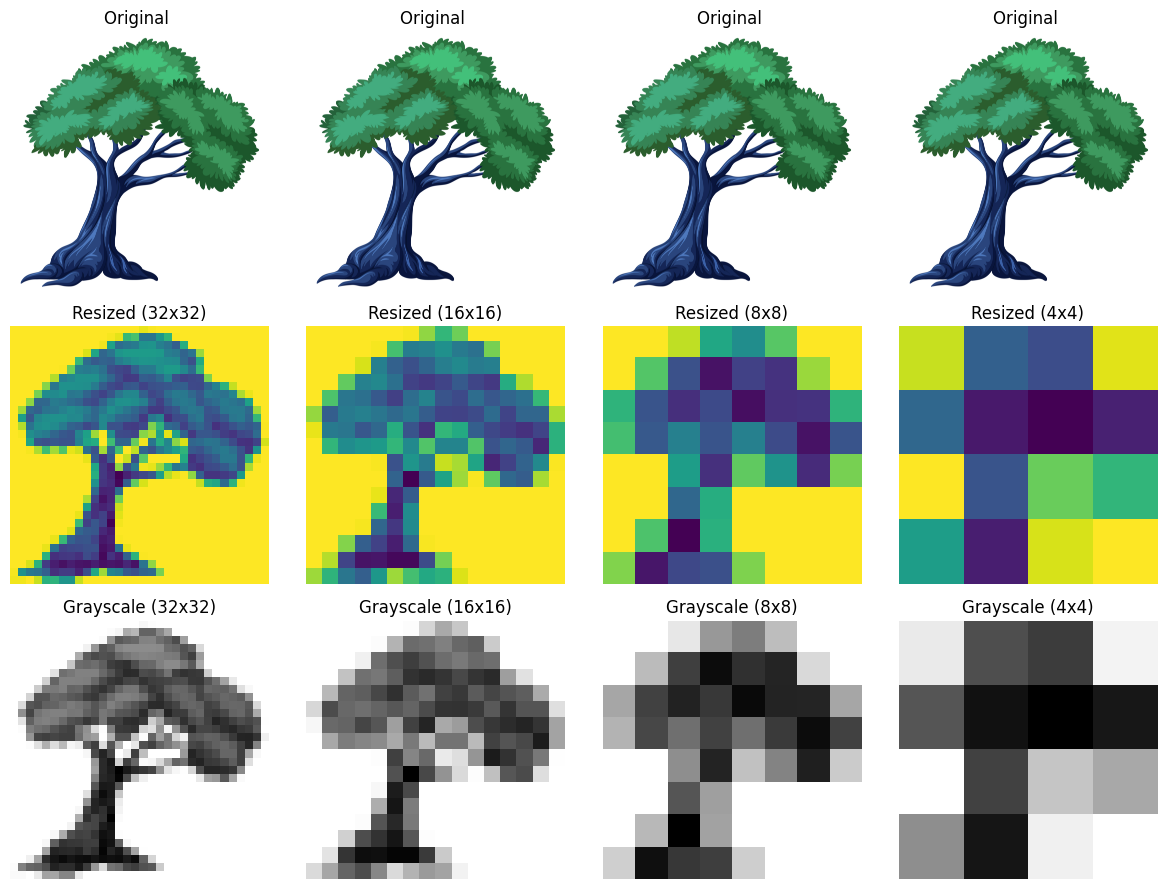

In [6]:
sizes = [32, 16, 8, 4]
img_resized = []
img_array = []

# Resize and convert to grayscale arrays
for size in sizes:
    # resized = img.resize((size, size)).convert("L")
    resized = cv.resize(gray_img, (size, size), interpolation=cv.INTER_AREA)
    img_resized.append(resized)
    img_array.append(np.array(resized))

# Plot in 3 rows × 4 columns
plt.figure(figsize=(12, 9))

# Row 1: Originals
for i, size in enumerate(sizes):
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f"Original ")
    plt.axis("off")

# Row 2: Resized
for i, size in enumerate(sizes):
    plt.subplot(3, 4, 4 + i+1)
    plt.imshow(img_resized[i])
    plt.title(f"Resized ({size}x{size})")
    plt.axis("off")

# Row 3: Grayscale
for i, size in enumerate(sizes):
    plt.subplot(3, 4, 8 + i+1)
    plt.imshow(img_array[i], cmap="gray")
    plt.title(f"Grayscale ({size}x{size})")
    plt.axis("off")

plt.tight_layout()
plt.show()





## Helper Function

In [7]:
def mcnot(qc, controls, target, ancillas=None):
    # Creating a multi-controlled X gate
    controlled_x = cirq.X(target).controlled_by(*controls)
    qc.append(controlled_x)
    return qc


##NEQR Encoding Function

In [8]:
def encode_neqr(sample_img):
    Y, X = sample_img.shape

    # Number of qubits required
    num_intensity = 8  # grayscale 0-255
    num_pos_y = int(np.ceil(np.log2(Y)))
    num_pos_x = int(np.ceil(np.log2(X)))
    num_position = num_pos_y + num_pos_x
    num_ancillas = 2  # helper qubits if needed

    # Create qubits
    intensity_qubits = [cirq.NamedQubit(f'i{i}') for i in range(num_intensity)]
    position_qubits = [cirq.NamedQubit(f'p{i}') for i in range(num_position)]
    ancilla_qubits = [cirq.NamedQubit(f'a{i}') for i in range(num_ancillas)]

    qc = cirq.Circuit()

    # Step 1: Put position register into superposition
    for q in position_qubits:
        qc.append(cirq.H(q))

    # Step 2: Encode each pixel
    for y in range(Y):
        for x in range(X):
            val = sample_img[y, x]
            if val == 0:
                continue  # skip zero pixels

            # Binary representation of position
            y_bin = np.binary_repr(y, width=num_pos_y)
            x_bin = np.binary_repr(x, width=num_pos_x)
            pos_bits = y_bin + x_bin

            # Set position with X gates
            for idx, bit in enumerate(pos_bits):
                if bit == '1':
                    qc.append(cirq.X(position_qubits[idx]))

            # Binary representation of intensity
            val_bin = np.binary_repr(val, width=num_intensity)

            # Apply multi-controlled X for each intensity qubit
            for idx, bit in enumerate(val_bin[::-1]):  # LSB first
                if bit == '1':
                    mcnot(qc, controls=position_qubits, target=intensity_qubits[idx], ancillas=ancilla_qubits)

            # Reset position qubits
            for idx, bit in enumerate(pos_bits):
                if bit == '1':
                    qc.append(cirq.X(position_qubits[idx]))

    # Step 3: Measurement
    qc.append(cirq.measure(*intensity_qubits, key='intensity'))
    qc.append(cirq.measure(*position_qubits, key='position'))

    return qc


##Simulation

In [9]:
sim = cirq.Simulator()
#shots_list = [32768, 24576, 16384, 8192]  # adjustable shots per image size
shots_list = [400000, 400000, 400000,400000]  # adjustable shots per image size
circuit_list = []  # store NEQR circuits
counts_list = []   # store measurement counts

for i, img in enumerate(img_array):
    # 1. Encode the image into a NEQR circuit
    size_i = img.shape[0]
    qc_i = encode_neqr(img)
    circuit_list.append(qc_i)

    # 2. Run simulation
    repetitions = shots_list[i]
    result = sim.run(qc_i, repetitions=repetitions)

    # 3. Extract measurement arrays
    intensity_meas = result.measurements['intensity']
    position_meas = result.measurements['position']

    # 4. Convert measurements to counts dictionary
    counts_i = {}
    for j in range(repetitions):
        intensity_bits = "".join(str(b) for b in intensity_meas[j][::-1])  # LSB first
        position_bits = "".join(str(b) for b in position_meas[j][::-1])     # LSB first
        bitstring = intensity_bits + position_bits
        if bitstring in counts_i:
            counts_i[bitstring] += 1
        else:
            counts_i[bitstring] = 1

    counts_list.append(counts_i)


## Image Encoding

In [10]:
# circuit = [encode_neqr(img_array[i], measure=False) for i in range(len(sizes))]


# # Run the NEQR circuit on Cirq simulator
# counts = run_neqr(qc_img, shots=20000)



##Circuit Simulation

In [11]:

# sim = cirq.Simulator()
# repetitions = [32768, 24576, 16384, 8192]   #We can change the shots here for [32, 16, 8, 4] corresponding images sizes
# #repetitions = [400000, 400000, 400000,400000]   #We can change the shots here for [32, 16, 8, 4] corresponding images sizes
# circuit_m = []
# hist = []

# for i in range(len(sizes)):
#     # Get image size
#     size_i = img_array[i].shape[0]

#     # 1. Encode image into FRQI circuit with measurement
#     circuit_i = frqi_encode(img_array[i], measure=True)
#     circuit_m.append(circuit_i)

#     # 2. Run simulation + get histogram
#     hist_i = frqi_simulate_measure(circuit_i, sim, repetitions=repetitions[i], size=size_i)
#     hist.append(hist_i)




## Reconstruction function

In [17]:
def decode_neqr(counts, height, width):
    num_pixels = height * width
    num_pos_qubits = int(np.ceil(np.log2(num_pixels)))

    # Initialize reconstructed image
    recon_img = np.zeros((height, width), dtype=np.uint8)

    for state, freq in counts.items():
        # Bitstring already has no spaces
        # Split intensity + position bits
        intensity_bits = state[-(8 + num_pos_qubits):-num_pos_qubits] if num_pos_qubits > 0 else state[-8:]
        position_bits = state[-num_pos_qubits:] if num_pos_qubits > 0 else "0"

        intensity_val = int(intensity_bits[::], 2)  # LSB first
        pos_val = int(position_bits[::-1], 2)

        y, x = divmod(pos_val, width)
        recon_img[y, x] = intensity_val

    recon_img = np.rot90(recon_img, 2)

    return recon_img


##Image reconstruction

In [18]:
# 3. Reconstruct image from histograms
reconstructed = []
for i in range(len(sizes)):
  reconstructed.append(decode_neqr(counts_list[i], sizes[i], sizes[i]))



##Evaluation

In [19]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


def evaluate_reconstruction(original, reconstructed):
    # Convert to float64
    original = np.array(original, dtype=np.float64)
    reconstructed = np.array(reconstructed, dtype=np.float64)


    # Clip to valid range
    original = np.clip(original, 0, 255)
    reconstructed = np.clip(reconstructed, 0, 255)

    # PSNR
    psnr_val = peak_signal_noise_ratio(original, reconstructed, data_range=255)

    # Determine appropriate win_size for SSIM
    min_dim = min(original.shape)
    win_size = min(min_dim, 7)  # default is 7
    if win_size % 2 == 0:
        win_size -= 1  # make it odd

    # SSIM
    ssim_val = structural_similarity(original, reconstructed, data_range=255, win_size=win_size)

    return psnr_val, ssim_val


# Compute PSNR and SSIM for all image sizes
psnr_vals = []
ssim_vals = []

for i in range(len(sizes)):
    psnr, ssim = evaluate_reconstruction(img_array[i], reconstructed[i])
    psnr_vals.append(psnr)
    ssim_vals.append(ssim)
    print(f"Size {sizes[i]}x{sizes[i]} -> PSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}")


Size 32x32 -> PSNR: inf dB, SSIM: 1.0000
Size 16x16 -> PSNR: inf dB, SSIM: 1.0000
Size 8x8 -> PSNR: inf dB, SSIM: 1.0000
Size 4x4 -> PSNR: inf dB, SSIM: 1.0000


/usr/local/lib/python3.12/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


##Overall result

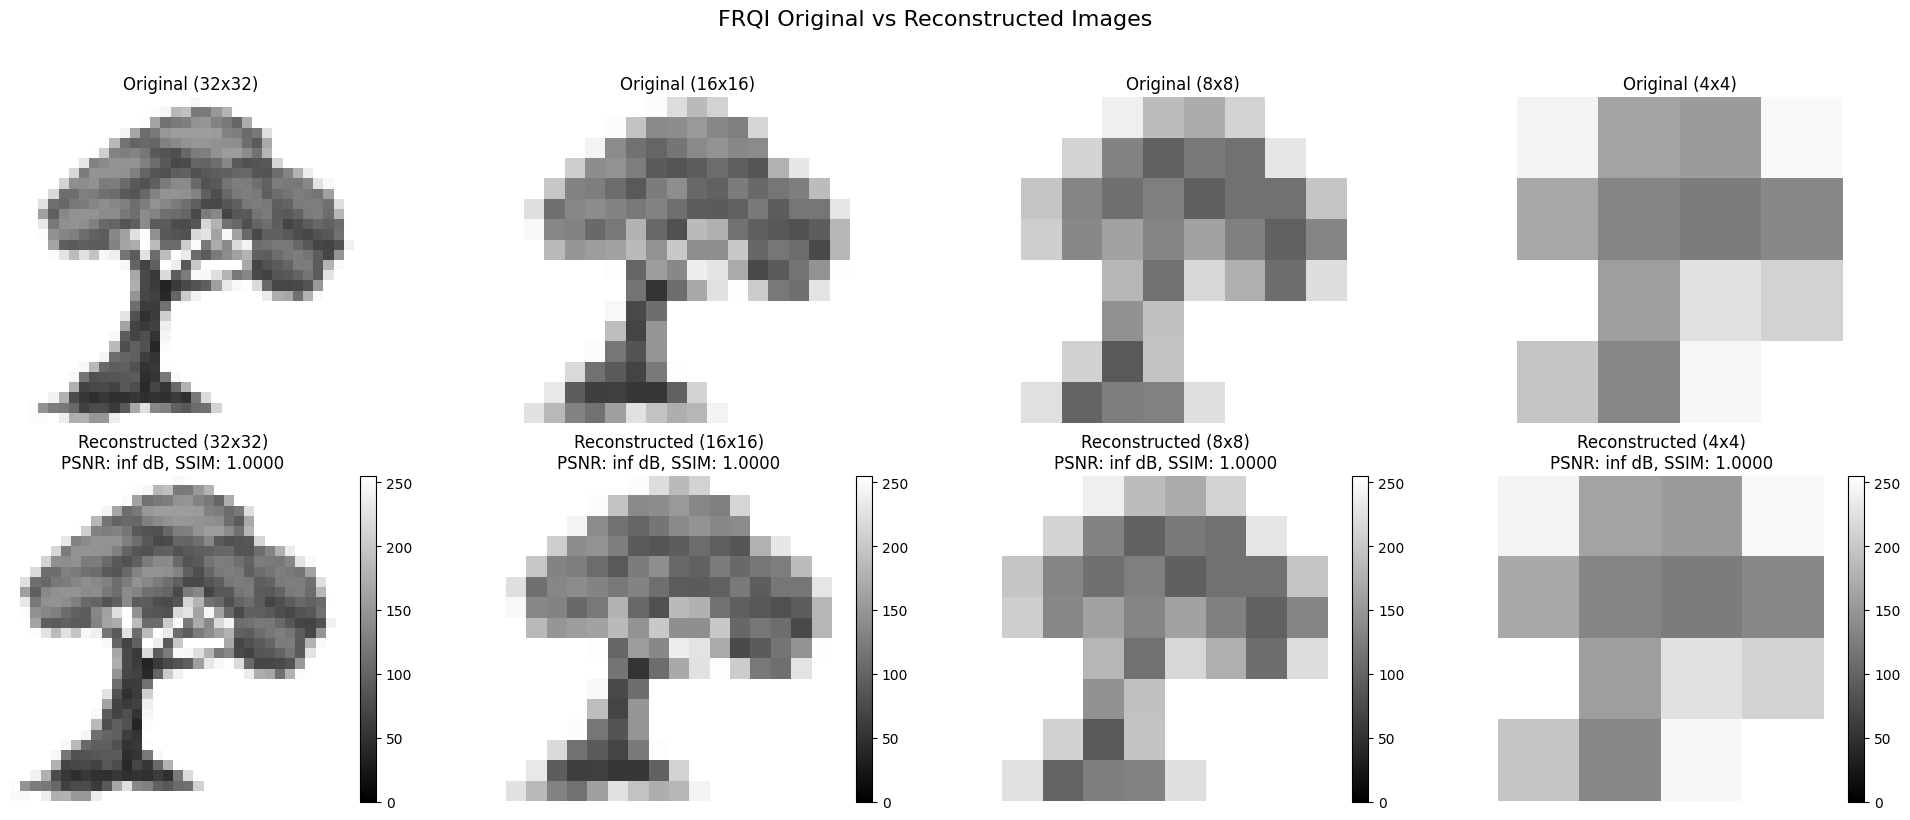

In [20]:

n = len(sizes)  # number of image sizes
fig, axes = plt.subplots(2, n, figsize=(5*n, 8))
fig.suptitle("FRQI Original vs Reconstructed Images", fontsize=16, y=1.02)
# Row 1: Original images
for i in range(n):
    axes[0, i].imshow(img_array[i], cmap="gray", vmin=0, vmax=255)
    axes[0, i].set_title(f"Original ({sizes[i]}x{sizes[i]})")
    axes[0, i].axis("off")

# Row 2: Reconstructed images
for i in range(n):
    im = axes[1, i].imshow(reconstructed[i], cmap="gray", vmin=0, vmax=255)
    axes[1, i].set_title(f"Reconstructed ({sizes[i]}x{sizes[i]})\nPSNR: {psnr_vals[i]:.2f} dB, SSIM: {ssim_vals[i]:.4f}")
    axes[1, i].axis("off")
    fig.colorbar(im, ax=axes[1, i])

plt.tight_layout()
plt.show()

In [21]:
n = len(sizes)  # number of images

for i in range(n):
    print(f"\n=== Image {i+1} ({sizes[i]}x{sizes[i]}) ===")
    print("Original Image Matrix:")
    print(img_array[i])
    print("\nReconstructed Image Matrix:")
    print(reconstructed[i])



=== Image 1 (32x32) ===
Original Image Matrix:
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 242 ... 255 255 255]
 [252 147 124 ... 255 255 255]
 [250 250 255 ... 255 255 255]]

Reconstructed Image Matrix:
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 242 ... 255 255 255]
 [252 147 124 ... 255 255 255]
 [250 250 255 ... 255 255 255]]

=== Image 2 (16x16) ===
Original Image Matrix:
[[255 255 255 255 255 255 252 221 186 210 255 255 255 255 255 255]
 [255 255 255 255 252 195 137 141 153 134 127 213 255 255 255 255]
 [255 255 255 243 139 114 101 117 138 148 136 139 255 255 255 255]
 [255 255 206 141 146 126  91  85  93 109  94  85 177 231 255 255]
 [255 198 131 126 108  90 124 142 104  97 124 106 118 126 188 255]
 [223 112 134 140 131 121 131 111  92  91  98 122  93 118 118 229]
 [248 135 131 106 120 178 104  80 186 176 113  95  87  80  93 182]
 [255 185 150 157 162 